<a href="https://colab.research.google.com/github/Miklneuro/SPARK_covid-19/blob/main/SPARK_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

In [ ]:
cd D:\SPARK_COVID\covid-chestxray-dataset

D:\SPARK_COVID\covid-chestxray-dataset


In [ ]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findspark

In [ ]:
import os
import sys

# Полностью очищаем и переустанавливаем PATH для Java
java_home = r'C:\Program Files\Microsoft\jdk-17.0.17.10-hotspot'
java_bin = os.path.join(java_home, 'bin')

# Получаем текущий PATH и убираем все существующие Java пути
current_path = os.environ.get('PATH', '').split(';')
filtered_path = [p for p in current_path if 'java' not in p.lower() and 'jdk' not in p.lower()]

# Собираем новый PATH с Java 17 в начале
new_path = [java_bin] + filtered_path
os.environ['PATH'] = ';'.join(new_path)
os.environ['JAVA_HOME'] = java_home
os.environ['HADOOP_HOME'] = ""

print("Java setup complete")
print("JAVA_HOME:", os.environ.get('JAVA_HOME'))

# Проверяем Java
import subprocess
result = subprocess.run(['java', '-version'], capture_output=True, text=True)
print("Java check:", result.stderr.split('\n')[0] if result.stderr else "No output")

Java setup complete
JAVA_HOME: C:\Program Files\Microsoft\jdk-17.0.17.10-hotspot
Java check: openjdk version "17.0.17" 2025-10-21 LTS


In [ ]:
try:
    import findspark
    findspark.init()
    print("findspark initialized successfully")
except Exception as e:
    print("findspark error:", e)

try:
    from pyspark.sql import SparkSession
    print("PySpark imports work")
except Exception as e:
    print("PySpark import error:", str(e))
    import traceback
    traceback.print_exc()

findspark initialized successfully
PySpark imports work


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
cd  D:\SPARK_COVID\covid-chestxray-dataset

D:\SPARK_COVID\covid-chestxray-dataset


In [ ]:
import os
from pyspark.sql import SparkSession

# Устанавливаем переменные
os.environ['JAVA_HOME'] = r'C:\Program Files\Microsoft\jdk-17.0.17.10-hotspot'
os.environ['HADOOP_HOME'] = ""

# Создаем Spark сессию
spark = SparkSession.builder \
    .appName("COVID-19 Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

print("Spark session created successfully!")
print("Spark version:", spark.version)

# Загружаем данные COVID
df = spark.read.csv("D:/SPARK_COVID/covid-chestxray-dataset/metadata.csv",
                   header=True,
                   inferSchema=True)

# Показываем информацию о данных
print("Data loaded! Schema:")
df.printSchema()
print("Row count:", df.count())
print("First 10 rows:")
df.show(10, truncate=False)

Spark session created successfully!
Spark version: 4.0.1
Data loaded! Schema:
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable 

In [ ]:
# Анализируем количество пропусков в каждом столбце
print("Анализ пропусков в данных:")
print("=" * 50)

null_analysis = []
for column in df.columns:
    null_count = df.filter(df[column].isNull()).count()
    total_count = df.count()
    null_percentage = (null_count / total_count) * 100
    null_analysis.append((column, null_count, null_percentage))

# Сортируем по убыванию процента пропусков
null_analysis.sort(key=lambda x: x[2], reverse=True)

# Выводим результаты
print(f"{'Колонка':<30} {'Пропуски':<10} {'%':<10}")
print("-" * 50)
for col, null_count, null_perc in null_analysis:
    print(f"{col:<30} {null_count:<10} {null_perc:<10.2f}")

# Определяем критические колонки с пропусками > 50%
critical_columns = [col for col, _, perc in null_analysis if perc > 50]
print(f"\nКритические колонки (>50% пропусков): {critical_columns}")

Анализ пропусков в данных:
Колонка                        Пропуски   %         
--------------------------------------------------
_c29                           935        98.42     
leukocyte_count                934        98.32     
neutrophil_count               922        97.05     
extubated                      913        96.11     
lymphocyte_count               910        95.79     
temperature                    872        91.79     
needed_supplemental_O2         860        90.53     
pO2_saturation                 831        87.47     
intubated                      702        73.89     
intubation_present             700        73.68     
in_icu                         615        64.74     
survival                       589        62.00     
doi                            568        59.79     
went_icu                       553        58.21     
other_notes                    510        53.68     
RT_PCR_positive                357        37.58     
date                 

In [ ]:
# Покажем примеры данных для понимания контекста
print("ПРИМЕРЫ ДАННЫХ ДЛЯ ПОНИМАНИЯ КОНТЕКСТА:")
print("=" * 60)

# Покажем несколько строк с пропусками
print("Примеры строк с пропусками в ключевых колонках:")
sample_df = df.select(['patientid', 'age', 'sex', 'finding', 'intubated', 'survival', 'RT_PCR_positive']).limit(5)
sample_df.show()

print("\nОБЪЯСНЕНИЕ СТРАТЕГИИ ЗАПОЛНЕНИЯ:")
print("=" * 60)

# Объяснение для каждой группы колонок
strategies = {
    'КАТЕГОРИЙНЫЕ (статусы)': {
        'колонки': ['intubated', 'intubation_present', 'in_icu', 'survival', 'went_icu', 'RT_PCR_positive'],
        'объяснение': 'Заполняем "Unknown" - это честно указывает на отсутствие информации о статусе',
        'пример': 'intubated: Y/N/Unknown'
    },
    'ТЕКСТОВЫЕ (описания)': {
        'колонки': ['other_notes', 'clinical_notes', 'doi', 'license'],
        'объяснение': 'Заполняем нейтральными значениями "No notes", "Not available"',
        'пример': 'clinical_notes: "No clinical notes"'
    },
    'ЧИСЛОВЫЕ (возраст, смещение)': {
        'колонки': ['age', 'offset'],
        'объяснение': 'Заполняем -1 чтобы отличать от реальных значений при анализе',
        'пример': 'age: 45 (реальный) vs -1 (пропуск)'
    },
    'ДЕМОГРАФИЧЕСКИЕ': {
        'колонки': ['sex', 'date'],
        'объяснение': 'Заполняем "Unknown" для сохранения структуры данных',
        'пример': 'sex: "M"/"F"/"Unknown"'
    }
}

for group, info in strategies.items():
    print(f"\n{group}:")
    print(f"  Колонки: {info['колонки']}")
    print(f"  Стратегия: {info['объяснение']}")
    print(f"  Пример: {info['пример']}")

print("\nЦЕЛЬ: Сохранить максимум данных для анализа, но честно маркировать пропуски")

ПРИМЕРЫ ДАННЫХ ДЛЯ ПОНИМАНИЯ КОНТЕКСТА:
Примеры строк с пропусками в ключевых колонках:
+---------+---+---+--------------------+---------+--------+---------------+
|patientid|age|sex|             finding|intubated|survival|RT_PCR_positive|
+---------+---+---+--------------------+---------+--------+---------------+
|        2| 65|  M|Pneumonia/Viral/C...|        N|       Y|              Y|
|        2| 65|  M|Pneumonia/Viral/C...|        N|       Y|              Y|
|        2| 65|  M|Pneumonia/Viral/C...|        N|       Y|              Y|
|        2| 65|  M|Pneumonia/Viral/C...|        N|       Y|              Y|
|        4| 52|  F|Pneumonia/Viral/C...|        N|    NULL|              Y|
+---------+---+---+--------------------+---------+--------+---------------+


ОБЪЯСНЕНИЕ СТРАТЕГИИ ЗАПОЛНЕНИЯ:

КАТЕГОРИЙНЫЕ (статусы):
  Колонки: ['intubated', 'intubation_present', 'in_icu', 'survival', 'went_icu', 'RT_PCR_positive']
  Стратегия: Заполняем "Unknown" - это честно указывает на отсутстви

In [ ]:
# Разделяем колонки по стратегиям обработки
print("СТРАТЕГИЯ ОБРАБОТКИ ПРОПУСКОВ:")
print("=" * 60)

# 1. Колонки для УДАЛЕНИЯ (пропуски >90%)
drop_columns = ['_c29', 'leukocyte_count', 'neutrophil_count', 'extubated',
                'lymphocyte_count', 'temperature', 'needed_supplemental_O2',
                'pO2_saturation']
print(f"1. УДАЛИТЬ колонки (>90% пропусков): {drop_columns}")

# 2. Колонки для ЗАПОЛНЕНИЯ КОНКРЕТНЫМИ ЗНАЧЕНИЯМИ
fill_strategy = {
    'intubated': 'Unknown',           # Статус интубации
    'intubation_present': 'Unknown',  # Наличие интубации
    'in_icu': 'Unknown',              # Статус в ICU
    'survival': 'Unknown',            # Статус выживания
    'went_icu': 'Unknown',            # Факт попадания в ICU
    'other_notes': 'No notes',        # Дополнительные заметки
    'RT_PCR_positive': 'Unknown',     # Статус ПЦР теста
    'doi': 'Not available',           # DOI статьи
    'age': -1,                        # Возраст (заполним -1 для анализа)
    'sex': 'Unknown',                 # Пол
    'date': 'Unknown',                # Дата
    'offset': -1,                     # Смещение
    'license': 'Not specified',       # Лицензия
    'clinical_notes': 'No clinical notes'  # Клинические заметки
}

print(f"\n2. ЗАПОЛНИТЬ колонки стратегическими значениями:")
for col, value in fill_strategy.items():
    null_count = df.filter(df[col].isNull()).count()
    print(f"   - {col:<25} -> {value:<15} (пропусков: {null_count})")

# 3. Колонки для СОХРАНЕНИЯ (мало пропусков)
keep_columns = ['patientid', 'finding', 'view', 'modality', 'folder', 'filename', 'url', 'location']
print(f"\n3. СОХРАНИТЬ колонки (важные для анализа): {keep_columns}")

СТРАТЕГИЯ ОБРАБОТКИ ПРОПУСКОВ:
1. УДАЛИТЬ колонки (>90% пропусков): ['_c29', 'leukocyte_count', 'neutrophil_count', 'extubated', 'lymphocyte_count', 'temperature', 'needed_supplemental_O2', 'pO2_saturation']

2. ЗАПОЛНИТЬ колонки стратегическими значениями:
   - intubated                 -> Unknown         (пропусков: 702)
   - intubation_present        -> Unknown         (пропусков: 700)
   - in_icu                    -> Unknown         (пропусков: 615)
   - survival                  -> Unknown         (пропусков: 589)
   - went_icu                  -> Unknown         (пропусков: 553)
   - other_notes               -> No notes        (пропусков: 510)
   - RT_PCR_positive           -> Unknown         (пропусков: 357)
   - doi                       -> Not available   (пропусков: 568)
   - age                       -> -1              (пропусков: 237)
   - sex                       -> Unknown         (пропусков: 80)
   - date                      -> Unknown         (пропусков: 289)
   - o

In [ ]:
from pyspark.sql.functions import when, col, lit

print("НАЧИНАЕМ ОБРАБОТКУ ПРОПУСКОВ:")
print("=" * 50)

# 1. Удаляем колонки с >90% пропусков
print("1. Удаляем колонки с >90% пропусков...")
df_cleaned = df.drop(*['_c29', 'leukocyte_count', 'neutrophil_count', 'extubated',
                      'lymphocyte_count', 'temperature', 'needed_supplemental_O2',
                      'pO2_saturation'])

print(f"   Осталось колонок: {len(df_cleaned.columns)}")

# 2. Заполняем пропуски стратегическими значениями
print("\n2. Заполняем пропуски...")

# Словарь с преобразованиями
fill_operations = {
    'intubated': lit('Unknown'),
    'intubation_present': lit('Unknown'),
    'in_icu': lit('Unknown'),
    'survival': lit('Unknown'),
    'went_icu': lit('Unknown'),
    'other_notes': lit('No notes'),
    'RT_PCR_positive': lit('Unknown'),
    'doi': lit('Not available'),
    'age': lit(-1),
    'sex': lit('Unknown'),
    'date': lit('Unknown'),
    'offset': lit(-1),
    'license': lit('Not specified'),
    'clinical_notes': lit('No clinical notes')
}

# Применяем заполнение для каждой колонки
for column, fill_value in fill_operations.items():
    df_cleaned = df_cleaned.withColumn(
        column,
        when(col(column).isNull(), fill_value).otherwise(col(column))
    )
    null_count = df_cleaned.filter(col(column).isNull()).count()
    print(f"   - {column:<20}: заполнено, осталось пропусков: {null_count}")

# 3. Проверяем результат
print("\n3. ПРОВЕРКА РЕЗУЛЬТАТА:")
print(f"   Исходное количество строк: {df.count()}")
print(f"   Количество строк после очистки: {df_cleaned.count()}")
print(f"   Колонки после обработки: {len(df_cleaned.columns)}")

# Проверяем что пропусков нет
print("\n4. ФИНАЛЬНАЯ ПРОВЕРКА НА ПРОПУСКИ:")
for column in df_cleaned.columns:
    null_count = df_cleaned.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"     {column}: {null_count} пропусков")
    else:
        print(f"    {column}: пропусков нет")

print("\nОбработка завершена! Данные готовы для анализа.")

НАЧИНАЕМ ОБРАБОТКУ ПРОПУСКОВ:
1. Удаляем колонки с >90% пропусков...
   Осталось колонок: 22

2. Заполняем пропуски...
   - intubated           : заполнено, осталось пропусков: 0
   - intubation_present  : заполнено, осталось пропусков: 0
   - in_icu              : заполнено, осталось пропусков: 0
   - survival            : заполнено, осталось пропусков: 0
   - went_icu            : заполнено, осталось пропусков: 0
   - other_notes         : заполнено, осталось пропусков: 0
   - RT_PCR_positive     : заполнено, осталось пропусков: 0
   - doi                 : заполнено, осталось пропусков: 0
   - age                 : заполнено, осталось пропусков: 0
   - sex                 : заполнено, осталось пропусков: 0
   - date                : заполнено, осталось пропусков: 0
   - offset              : заполнено, осталось пропусков: 0
   - license             : заполнено, осталось пропусков: 0
   - clinical_notes      : заполнено, осталось пропусков: 0

3. ПРОВЕРКА РЕЗУЛЬТАТА:
   Исходное коли

In [ ]:
from pyspark.sql.functions import col

print("ФИНАЛЬНАЯ ОЧИСТКА И ПОДГОТОВКА ДАННЫХ:")
print("=" * 50)

# Заполняем пропуски в location
df_final = df_cleaned.withColumn(
    "location",
    when(col("location").isNull(), "Location not specified").otherwise(col("location"))
)

print("1. Заполнены пропуски в location: 'Location not specified'")

# Проверяем что ВСЕ пропуски устранены
print("\n2. ФИНАЛЬНАЯ ПРОВЕРКА:")
null_check = []
for column in df_final.columns:
    null_count = df_final.filter(col(column).isNull()).count()
    null_check.append((column, null_count))

final_null_columns = [col for col, count in null_check if count > 0]

if not final_null_columns:
    print("    ВСЕ ПРОПУСКИ УСТРАНЕНЫ!")
else:
    print(f"     Остались пропуски в: {final_null_columns}")

# Покажем структуру очищенных данных
print("\n3. СТРУКТУРА ОЧИЩЕННЫХ ДАННЫХ:")
print(f"   - Всего записей: {df_final.count()}")
print(f"   - Всего колонок: {len(df_final.columns)}")
print(f"   - Ключевые колонки для анализа:")
key_columns = ['patientid', 'age', 'sex', 'finding', 'RT_PCR_positive', 'survival', 'view', 'modality']
for col in key_columns:
    print(f"      * {col}")



ФИНАЛЬНАЯ ОЧИСТКА И ПОДГОТОВКА ДАННЫХ:
1. Заполнены пропуски в location: 'Location not specified'

2. ФИНАЛЬНАЯ ПРОВЕРКА:
    ВСЕ ПРОПУСКИ УСТРАНЕНЫ!

3. СТРУКТУРА ОЧИЩЕННЫХ ДАННЫХ:
   - Всего записей: 950
   - Всего колонок: 22
   - Ключевые колонки для анализа:
      * patientid
      * age
      * sex
      * finding
      * RT_PCR_positive
      * survival
      * view
      * modality


In [ ]:
# СОЗДАНИЕ ОЧИЩЕННОЙ ПЕРЕМЕННОЙ И СОХРАНЕНИЕ
print("СОЗДАНИЕ ОЧИЩЕННОЙ ПЕРЕМЕННОЙ И СОХРАНЕНИЕ:")
print("=" * 50)

from pyspark.sql.functions import when, col

# Создаем окончательную очищенную версию данных
df_final_cleaned = df_cleaned.withColumn(
    "location",
    when(col("location").isNull(), "Location not specified").otherwise(col("location"))
)

print(" Создана очищенная переменная: df_final_cleaned")

СОЗДАНИЕ ОЧИЩЕННОЙ ПЕРЕМЕННОЙ И СОХРАНЕНИЕ:
 Создана очищенная переменная: df_final_cleaned


In [ ]:
from pyspark.sql.functions import when, col, lower

print("АНАЛИЗ ДИАГНОЗОВ ДЛЯ УНИФИКАЦИИ:")
print("=" * 50)

# Анализируем текущие диагнозы
print("1. ТЕКУЩЕЕ РАЗНООБРАЗИЕ ДИАГНОЗОВ:")
diagnosis_counts = df_final.groupBy("finding").count().orderBy("count", ascending=False)
diagnosis_counts.show(truncate=False)

print("\n2. ПРЕДЛОЖЕНИЕ ПО УНИФИКАЦИИ КАТЕГОРИЙ:")
categories = {
    "COVID-19": "Диагнозы с COVID-19",
    "SARS": "Диагнозы с SARS",
    "MERS": "Диагнозы с MERS",
    "Viral Pneumonia": "Вирусные пневмонии (не COVID/SARS/MERS)",
    "Bacterial Pneumonia": "Бактериальные пневмонии",
    "Fungal Pneumonia": "Грибковые пневмонии",
    "Other Pneumonia": "Другие пневмонии",
    "Tuberculosis": "Туберкулез",
    "Normal": "Нормальные снимки",
    "Other": "Прочие диагнозы"
}

for category, description in categories.items():
    print(f"   - {category}: {description}")

АНАЛИЗ ДИАГНОЗОВ ДЛЯ УНИФИКАЦИИ:
1. ТЕКУЩЕЕ РАЗНООБРАЗИЕ ДИАГНОЗОВ:
+---------------------------------+-----+
|finding                          |count|
+---------------------------------+-----+
|Pneumonia/Viral/COVID-19         |584  |
|todo                             |83   |
|Pneumonia                        |81   |
|Pneumonia/Fungal/Pneumocystis    |30   |
|Pneumonia/Bacterial/Streptococcus|22   |
|No Finding                       |22   |
|Tuberculosis                     |18   |
|Pneumonia/Viral/SARS             |16   |
|Pneumonia/Lipoid                 |13   |
|Pneumonia/Bacterial/Mycoplasma   |11   |
|Pneumonia/Bacterial/Klebsiella   |10   |
|Pneumonia/Viral/MERS-CoV         |10   |
|Pneumonia/Bacterial/Legionella   |10   |
|Pneumonia/Bacterial/Nocardia     |8    |
|Pneumonia/Viral/Varicella        |6    |
|Pneumonia/Viral/Influenza        |5    |
|Pneumonia/Bacterial              |4    |
|Pneumonia/Bacterial/E.Coli       |4    |
|Pneumonia/Viral/Herpes           |3    |
|Pneumon

In [ ]:
from pyspark.sql.functions import when, col, lower

print("РЕАЛИЗАЦИЯ УНИФИКАЦИИ ДИАГНОЗОВ:")
print("=" * 50)

# Унификация диагнозов с помощью when/otherwise (без UDF)
df_unified = df_final.withColumn(
    "finding_category",
    when(lower(col("finding")).contains("covid"), "COVID-19")
    .when(lower(col("finding")).contains("sars"), "SARS")
    .when(lower(col("finding")).contains("mers"), "MERS")
    .when(lower(col("finding")).contains("bacterial"), "Bacterial Pneumonia")
    .when(lower(col("finding")).contains("fungal"), "Fungal Pneumonia")
    .when(lower(col("finding")).contains("lipoid"), "Other Pneumonia")
    .when(lower(col("finding")).contains("pneumocystis"), "Fungal Pneumonia")
    .when(lower(col("finding")).contains("viral"), "Viral Pneumonia")
    .when(lower(col("finding")).contains("tuberculosis"), "Tuberculosis")
    .when(lower(col("finding")).contains("no finding"), "Normal")
    .when(lower(col("finding")) == "todo", "Other")
    .when(lower(col("finding")) == "pneumonia", "Other Pneumonia")
    .otherwise("Other")
)

print("Унификация выполнена успешно!")

# Покажем результаты унификации
print("\nРЕЗУЛЬТАТЫ УНИФИКАЦИИ:")
category_counts = df_unified.groupBy("finding_category").count().orderBy("count", ascending=False)
category_counts.show(truncate=False)

# Покажем примеры преобразования
print("\nПРИМЕРЫ ПРЕОБРАЗОВАНИЯ:")
df_unified.select("finding", "finding_category").distinct().show(30, truncate=False)

# Сравнение до и после
print("\nСРАВНЕНИЕ ДО И ПОСЛЕ УНИФИКАЦИИ:")
print(f"ДО: {diagnosis_counts.count()} различных диагнозов")
print(f"ПОСЛЕ: {category_counts.count()} унифицированных категорий")

РЕАЛИЗАЦИЯ УНИФИКАЦИИ ДИАГНОЗОВ:
Унификация выполнена успешно!

РЕЗУЛЬТАТЫ УНИФИКАЦИИ:
+-------------------+-----+
|finding_category   |count|
+-------------------+-----+
|COVID-19           |584  |
|Other Pneumonia    |94   |
|Other              |85   |
|Bacterial Pneumonia|73   |
|Fungal Pneumonia   |32   |
|Normal             |22   |
|Tuberculosis       |18   |
|Viral Pneumonia    |16   |
|SARS               |16   |
|MERS               |10   |
+-------------------+-----+


ПРИМЕРЫ ПРЕОБРАЗОВАНИЯ:
+---------------------------------------+-------------------+
|finding                                |finding_category   |
+---------------------------------------+-------------------+
|Pneumonia/Bacterial/E.Coli             |Bacterial Pneumonia|
|Pneumonia/Bacterial/Staphylococcus/MRSA|Bacterial Pneumonia|
|todo                                   |Other              |
|Pneumonia/Bacterial/Klebsiella         |Bacterial Pneumonia|
|Pneumonia/Lipoid                       |Other Pneumonia    |

In [ ]:
from pyspark.sql.functions import col

print("УДАЛЕНИЕ ДУБЛИКАТОВ:")
print("=" * 50)

# Проверяем наличие полных дубликатов
print("1. ПРОВЕРКА ПОЛНЫХ ДУБЛИКАТОВ:")
total_rows_before = df_unified.count()
distinct_rows = df_unified.distinct().count()

print(f"   Всего строк до: {total_rows_before}")
print(f"   Уникальных строк: {distinct_rows}")
print(f"   Полных дубликатов: {total_rows_before - distinct_rows}")

# Проверяем дубликаты по ключевым полям
print("\n2. ПРОВЕРКА ДУБЛИКАТОВ ПО КЛЮЧЕВЫМ ПОЛЯМ:")
key_columns = ['patientid', 'filename', 'finding_category', 'view', 'modality']
duplicates_count = df_unified.groupBy(key_columns).count().filter("count > 1").count()
print(f"   Дубликатов по ключевым полям: {duplicates_count}")

if duplicates_count > 0:
    print("\n   ПРИМЕРЫ ДУБЛИКАТОВ:")
    duplicates_examples = df_unified.groupBy(key_columns).count().filter("count > 1").limit(5)
    duplicates_examples.show(truncate=False)

    # Покажем полную информацию о дубликатах
    print("\n   ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О ДУБЛИКАТАХ:")
    duplicate_keys = duplicates_examples.select(key_columns).collect()
    for key in duplicate_keys[:3]:  # Покажем первые 3
        print(f"\n   Дубликаты для: {key}")
        df_unified.filter(
            (col('patientid') == key['patientid']) &
            (col('filename') == key['filename']) &
            (col('finding_category') == key['finding_category'])
        ).select(['patientid', 'filename', 'finding_category', 'view', 'modality', 'age', 'sex']).show()
else:
    print("   Дубликатов по ключевым полям не найдено!")

# Удаляем полные дубликаты
print("\n3. УДАЛЕНИЕ ПОЛНЫХ ДУБЛИКАТОВ:")
df_final_cleaned = df_unified.distinct()

print(f"   Строк после удаления дубликатов: {df_final_cleaned.count()}")
print(f"   Удалено полных дубликатов: {total_rows_before - df_final_cleaned.count()}")

print("\n ПРЕДОБРАБОТКА ДАННЫХ ЗАВЕРШЕНА!")

УДАЛЕНИЕ ДУБЛИКАТОВ:
1. ПРОВЕРКА ПОЛНЫХ ДУБЛИКАТОВ:
   Всего строк до: 950
   Уникальных строк: 950
   Полных дубликатов: 0

2. ПРОВЕРКА ДУБЛИКАТОВ ПО КЛЮЧЕВЫМ ПОЛЯМ:
   Дубликатов по ключевым полям: 0
   Дубликатов по ключевым полям не найдено!

3. УДАЛЕНИЕ ПОЛНЫХ ДУБЛИКАТОВ:
   Строк после удаления дубликатов: 950
   Удалено полных дубликатов: 0

 ПРЕДОБРАБОТКА ДАННЫХ ЗАВЕРШЕНА!


In [ ]:
from pyspark.sql.functions import col, count, when, lit

print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ВОЗРАСТА И КАТЕГОРИАЛЬНЫХ ПОЛЕЙ")
print("=" * 60)

# Исправленный анализ распределения возраста
print("1. РАСПРЕДЕЛЕНИЕ ВОЗРАСТА ПО ГРУППАМ:")
age_groups = df_final_cleaned.filter(col("age") != -1).select(
    "age",
    when(col("age") < 20, "0-19")
    .when(col("age") < 30, "20-29")
    .when(col("age") < 40, "30-39")
    .when(col("age") < 50, "40-49")
    .when(col("age") < 60, "50-59")
    .when(col("age") < 70, "60-69")
    .when(col("age") < 80, "70-79")
    .otherwise("80+").alias("age_group")
)

age_group_stats = age_groups.groupBy("age_group").agg(
    count("*").alias("count"),
    (count("*") / lit(713) * 100).alias("percentage")  # 713 - valid ages
).orderBy("age_group")

age_group_stats.show()

# 2. Анализ категориальных полей на аномалии
print("\n2. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПОЛЕЙ:")

# Анализ поля sex
print("   - ПОЛ (sex):")
sex_counts = df_final_cleaned.groupBy("sex").count().orderBy("count", ascending=False)
sex_counts.show()

# Анализ поля survival
print("   - ВЫЖИВАЕМОСТЬ (survival):")
survival_counts = df_final_cleaned.groupBy("survival").count().orderBy("count", ascending=False)
survival_counts.show()

# Анализ поля RT_PCR_positive
print("   - ПЦР ТЕСТ (RT_PCR_positive):")
pcr_counts = df_final_cleaned.groupBy("RT_PCR_positive").count().orderBy("count", ascending=False)
pcr_counts.show()

АНАЛИЗ РАСПРЕДЕЛЕНИЯ ВОЗРАСТА И КАТЕГОРИАЛЬНЫХ ПОЛЕЙ
1. РАСПРЕДЕЛЕНИЕ ВОЗРАСТА ПО ГРУППАМ:
+---------+-----+------------------+
|age_group|count|        percentage|
+---------+-----+------------------+
|     0-19|    2|0.2805049088359046|
|    20-29|   64| 8.976157082748948|
|    30-39|   92|12.903225806451612|
|    40-49|  118| 16.54978962131837|
|    50-59|  144|20.196353436185134|
|    60-69|  119|16.690042075736326|
|    70-79|  136|19.074333800841515|
|      80+|   38| 5.329593267882188|
+---------+-----+------------------+


2. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПОЛЕЙ:
   - ПОЛ (sex):
+-------+-----+
|    sex|count|
+-------+-----+
|      M|  559|
|      F|  311|
|Unknown|   80|
+-------+-----+

   - ВЫЖИВАЕМОСТЬ (survival):
+--------+-----+
|survival|count|
+--------+-----+
| Unknown|  589|
|       Y|  285|
|       N|   76|
+--------+-----+

   - ПЦР ТЕСТ (RT_PCR_positive):
+---------------+-----+
|RT_PCR_positive|count|
+---------------+-----+
|              Y|  371|
|        Unknown|  357|

ДОКУМЕНТИРОВАНИЕ ПРОБЛЕМ КАЧЕСТВА ДАННЫХ
============================================================
ОБНАРУЖЕННЫЕ ПРОБЛЕМЫ ДАННЫХ:
========================================

1. Высокий процент неизвестных значений выживаемости
   Поле: survival
   Детали: 62% записей (589 из 950) имеют статус 'Unknown'
   Влияние: Ограничивает анализ смертности и факторов риска
   Рекомендация: Учесть при интерпретации результатов анализа выживаемости

2. Значительная доля неизвестных ПЦР-тестов
   Поле: RT_PCR_positive
   Детали: 38% записей (357 из 950) имеют статус 'Unknown', 23% - 'Unclear'
   Влияние: Сложность анализа точности диагностики COVID-19
   Рекомендация: Разделить анализ на подтвержденные и неподтвержденные случаи

3. Неравномерное распределение по возрасту
   Поле: age
   Детали: Только 2 пациента младше 20 лет, преобладание возрастных групп 50-79 лет
   Влияние: Ограниченная репрезентативность для молодых возрастных групп
   Рекомендация: Учесть при анализе возрастных факторов риска

4. Дисбаланс по полу
   Поле: sex
   Детали: 64% пациентов мужского пола (559 из 870 с известным полом)
   Влияние: Возможное смещение в анализе гендерных различий
   Рекомендация: Учесть при анализе гендерной статистики

5. Отсутствие данных о возрасте для 25% пациентов
   Поле: age
   Детали: 237 записей из 950 имеют возраст -1 (заполненные пропуски)
   Влияние: Ограничивает полный демографический анализ
   Рекомендация: Проводить анализ возраста только на валидных данных (713 записей)

ВЫВОД: Данные требуют осторожной интерпретации с учетом указанных ограничений

In [ ]:
# Запрос 1: Базовая статистика по диагнозам
print("ЗАПРОС 1: БАЗОВАЯ СТАТИСТИКА ПО ДИАГНОЗАМ")
print("=" * 50)

query_1 = """
SELECT
    finding_category,
    COUNT(*) as total_cases,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df_table), 2) as percentage,
    AVG(CASE WHEN age != -1 THEN age ELSE NULL END) as avg_age,
    COUNT(CASE WHEN sex = 'M' THEN 1 END) as male_count,
    COUNT(CASE WHEN sex = 'F' THEN 1 END) as female_count
FROM df_table
GROUP BY finding_category
ORDER BY total_cases DESC
"""

# Создаем временное представление для SQL запросов
df_final_cleaned.createOrReplaceTempView("df_table")

# Выполняем запрос
result_1 = spark.sql(query_1)
result_1.show()

ЗАПРОС 1: БАЗОВАЯ СТАТИСТИКА ПО ДИАГНОЗАМ
+-------------------+-----------+----------+------------------+----------+------------+
|   finding_category|total_cases|percentage|           avg_age|male_count|female_count|
+-------------------+-----------+----------+------------------+----------+------------+
|           COVID-19|        584|     61.47| 56.30444444444444|       346|         175|
|    Other Pneumonia|         94|      9.89| 51.81720430107527|        41|          52|
|              Other|         85|      8.95|              74.0|        61|          23|
|Bacterial Pneumonia|         73|      7.68|49.945205479452056|        48|          24|
|   Fungal Pneumonia|         32|      3.37| 36.81481481481482|        25|           4|
|             Normal|         22|      2.32|              52.3|        11|          10|
|       Tuberculosis|         18|      1.89|42.411764705882355|        13|           5|
|    Viral Pneumonia|         16|      1.68|             45.75|         9|    

Базовая статистика по диагнозам

Основные выводы:

    Доминирование COVID-19: 61.47% всех случаев (584 из 950) составляют подтвержденные случаи COVID-19, что отражает специализацию датасета на пандемии коронавируса.

    Возрастные особенности:

        Средний возраст пациентов с COVID-19 - 56.3 лет

        Наибольший средний возраст в категории "Other" - 74 года

        Наименьший средний возраст у пациентов с грибковой пневмонией - 36.8 лет

    Гендерное распределение:

        Во всех категориях диагнозов преобладают мужчины

        Наиболее выраженный гендерный дисбаланс в категориях COVID-19 (346 мужчин vs 175 женщин) и Other (61 vs 23)

    Особые случаи:

        Категория MERS не имеет данных о возрасте

        В категории SARS необычное распределение по полу (5 мужчин vs 11 женщин)

Данные демонстрируют четкую эпидемиологическую картину с преобладанием COVID-19 случаев среди пациентов среднего и старшего возраста с выраженным гендерным дисбалансом в пользу мужчин.


In [ ]:
# Запрос 2: Распределение по полу и диагнозам
print("ЗАПРОС 2: РАСПРЕДЕЛЕНИЕ ПО ПОЛУ И ДИАГНОЗАМ")
print("=" * 50)

query_2 = """
SELECT
    finding_category,
    sex,
    COUNT(*) as cases_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY finding_category), 2) as percentage_in_diagnosis,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY sex), 2) as percentage_in_gender
FROM df_table
WHERE sex != 'Unknown'
GROUP BY finding_category, sex
ORDER BY finding_category, sex
"""

# Выполняем запрос
result_2 = spark.sql(query_2)
result_2.show(50)

ЗАПРОС 2: РАСПРЕДЕЛЕНИЕ ПО ПОЛУ И ДИАГНОЗАМ
+-------------------+---+-----------+-----------------------+--------------------+
|   finding_category|sex|cases_count|percentage_in_diagnosis|percentage_in_gender|
+-------------------+---+-----------+-----------------------+--------------------+
|Bacterial Pneumonia|  F|         24|                  33.33|                7.72|
|Bacterial Pneumonia|  M|         48|                  66.67|                8.59|
|           COVID-19|  F|        175|                  33.59|               56.27|
|           COVID-19|  M|        346|                  66.41|               61.90|
|   Fungal Pneumonia|  F|          4|                  13.79|                1.29|
|   Fungal Pneumonia|  M|         25|                  86.21|                4.47|
|             Normal|  F|         10|                  47.62|                3.22|
|             Normal|  M|         11|                  52.38|                1.97|
|              Other|  F|         23|      

Распределение по полу и диагнозам

Ключевые выводы:

    Выраженный гендерный дисбаланс в COVID-19:

        66.41% случаев COVID-19 приходится на мужчин (346 из 521 случая с известным полом)

        56.27% всех женщин в датасете имеют диагноз COVID-19

        61.90% всех мужчин в датасете имеют диагноз COVID-19

    Наибольший гендерный разрыв:

        Грибковая пневмония: 86.21% мужчин vs 13.79% женщин

        Категория "Other": 72.62% мужчин vs 27.38% женщин

        Туберкулез: 72.22% мужчин vs 27.78% женщин

    Обратная тенденция в SARS:

        Уникальное распределение: 68.75% женщин vs 31.25% мужчин

        Единственная категория с преобладанием женщин

    Сбалансированные распределения:

        Нормальные снимки: почти равное распределение (52.38% мужчин vs 47.62% женщин)

        Вирусная пневмония: умеренное преобладание мужчин (56.25% vs 43.75%)

Вывод: Данные подтверждают эпидемиологические наблюдения о более высокой уязвимости мужчин к респираторным заболеваниям, особенно к COVID-19, с исключением в случае SARS.


In [ ]:
# Запрос 3: Оконная функция - топ-3 по возрасту в каждой группе диагнозов
print("ЗАПРОС 3: ТОП-3 САМЫХ ВЗРОСЛЫХ ПАЦИЕНТОВ В КАЖДОЙ ГРУППЕ ДИАГНОЗОВ")
print("=" * 70)

query_3 = """
WITH RankedPatients AS (
    SELECT
        patientid,
        finding_category,
        age,
        sex,
        ROW_NUMBER() OVER (PARTITION BY finding_category ORDER BY age DESC) as age_rank
    FROM df_table
    WHERE age != -1
)
SELECT
    finding_category,
    age_rank,
    patientid,
    age,
    sex
FROM RankedPatients
WHERE age_rank <= 3
ORDER BY finding_category, age_rank
"""

# Выполняем запрос
result_3 = spark.sql(query_3)
result_3.show(50)

ЗАПРОС 3: ТОП-3 САМЫХ ВЗРОСЛЫХ ПАЦИЕНТОВ В КАЖДОЙ ГРУППЕ ДИАГНОЗОВ
+-------------------+--------+---------+---+---+
|   finding_category|age_rank|patientid|age|sex|
+-------------------+--------+---------+---+---+
|Bacterial Pneumonia|       1|      340| 80|  M|
|Bacterial Pneumonia|       2|      340| 80|  M|
|Bacterial Pneumonia|       3|       91| 80|  F|
|           COVID-19|       1|     326b| 94|  M|
|           COVID-19|       2|     324b| 93|  F|
|           COVID-19|       3|     324b| 93|  F|
|   Fungal Pneumonia|       1|      109| 70|  M|
|   Fungal Pneumonia|       2|      109| 70|  M|
|   Fungal Pneumonia|       3|      108| 50|  M|
|             Normal|       1|      315| 78|  F|
|             Normal|       2|      325| 78|  F|
|             Normal|       3|     313b| 75|  M|
|              Other|       1|      415| 74|  M|
|    Other Pneumonia|       1|      460| 90|  M|
|    Other Pneumonia|       2|      460| 90|  M|
|    Other Pneumonia|       3|      454| 78|  F|
| 

Реализована оконная функция ROW_NUMBER() для ранжирования пациентов по возрасту в разрезе категорий диагнозов с выводом топ-3 самых возрастных пациентов для каждой категории.

Результаты анализа:

    Возрастной максимум по категориям диагнозов:

        COVID-19: 94 года (мужчина)

        Other Pneumonia: 90 лет (мужчина)

        Bacterial Pneumonia: 80 лет (мужчина)

        SARS: 76 лет (мужчина)

        Tuberculosis: 78 лет (мужчина)

        Fungal Pneumonia: 70 лет (мужчина)

    Гендерное распределение в старшей возрастной группе:

        Мужчины преобладают в 6 из 8 категорий диагнозов

        Женщины лидируют только в категориях Normal и Viral Pneumonia

        В категории COVID-19 представлены оба пола в топ-3

    Выявленные особенности данных:

        Наличие дублирующихся записей пациентов (пациенты 340, 324b, 109 и др.)

        Широкий возрастной диапазон максимальных значений - от 70 до 94 лет

        Категория MERS отсутствует в результатах из-за недостатка данных о возрасте

In [ ]:
# Запрос 4: Анализ временных трендов по датам исследований
print("ЗАПРОС 4: АНАЛИЗ ВРЕМЕННЫХ ТРЕНДОВ ПО ДАТАМ ИССЛЕДОВАНИЙ")
print("=" * 60)

query_4 = """
SELECT
    date,
    finding_category,
    COUNT(*) as cases_count,
    SUM(COUNT(*)) OVER (PARTITION BY date ORDER BY date) as total_cases_per_date
FROM df_table
WHERE date != 'Unknown'
GROUP BY date, finding_category
ORDER BY date, cases_count DESC
"""

# Выполняем запрос
result_4 = spark.sql(query_4)
print(f"Всего записей с известными датами: {result_4.count()}")
result_4.show(30, truncate=False)

ЗАПРОС 4: АНАЛИЗ ВРЕМЕННЫХ ТРЕНДОВ ПО ДАТАМ ИССЛЕДОВАНИЙ
Всего записей с известными датами: 92
+-------------+-------------------+-----------+--------------------+
|date         |finding_category   |cases_count|total_cases_per_date|
+-------------+-------------------+-----------+--------------------+
|01/13/20     |COVID-19           |1          |1                   |
|03/06/20     |COVID-19           |1          |1                   |
|03/09/20     |Bacterial Pneumonia|2          |2                   |
|03/16/20     |COVID-19           |2          |2                   |
|11/27/19     |Other Pneumonia    |2          |2                   |
|12 March 2020|Normal             |1          |1                   |
|2/29/2020    |COVID-19           |2          |2                   |
|2004         |SARS               |11         |11                  |
|2007         |Fungal Pneumonia   |1          |1                   |
|2010         |Fungal Pneumonia   |3          |3                   |
|2011   

In [ ]:
# запрос для общего распределения по годам
print("ОБЩЕЕ РАСПРЕДЕЛЕНИЕ СЛУЧАЕВ ПО ГОДАМ:")
yearly_totals = spark.sql("""
    WITH YearExtracted AS (
        SELECT
            CASE
                WHEN date LIKE '%2020' THEN '2020'
                WHEN date LIKE '%2019' THEN '2019'
                WHEN date LIKE '%2018' THEN '2018'
                WHEN date LIKE '%2017' THEN '2017'
                WHEN date LIKE '%2016' THEN '2016'
                WHEN date LIKE '%2015' THEN '2015'
                WHEN date LIKE '%2014' THEN '2014'
                WHEN date LIKE '%2013' THEN '2013'
                WHEN date LIKE '%2012' THEN '2012'
                WHEN date LIKE '%2011' THEN '2011'
                WHEN date LIKE '%2010' THEN '2010'
                WHEN date LIKE '%200%' THEN SUBSTRING(date, 1, 4)
                ELSE 'Other'
            END as year
        FROM df_table
        WHERE date != 'Unknown'
    )
    SELECT
        year,
        COUNT(*) as total_cases
    FROM YearExtracted
    GROUP BY year
    ORDER BY year
""")
yearly_totals.show()

# Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
print("\nЗАПРОС 5: СТАТИСТИКА ПО ПРОЕКЦИЯМ СНИМКОВ И СВЯЗИ С ДИАГНОЗАМИ")
print("=" * 70)

query_5 = """
SELECT
    view,
    finding_category,
    COUNT(*) as cases_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view), 2) as percentage_in_view,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY finding_category), 2) as percentage_in_diagnosis
FROM df_table
GROUP BY view, finding_category
ORDER BY view, cases_count DESC
"""

# Выполняем запрос
result_5 = spark.sql(query_5)
result_5.show(30, truncate=False)

ОБЩЕЕ РАСПРЕДЕЛЕНИЕ СЛУЧАЕВ ПО ГОДАМ:
+-----+-----------+
| year|total_cases|
+-----+-----------+
| 2004|         11|
| 2007|          1|
| 2010|          6|
| 2011|          5|
| 2013|          7|
| 2014|         11|
| 2015|         25|
| 2016|         20|
| 2017|          4|
| 2018|          6|
| 2019|          8|
| 2020|        538|
| Marc|          5|
|Other|         11|
| Sept|          3|
+-----+-----------+


ЗАПРОС 5: СТАТИСТИКА ПО ПРОЕКЦИЯМ СНИМКОВ И СВЯЗИ С ДИАГНОЗАМИ
+---------+-------------------+-----------+------------------+-----------------------+
|view     |finding_category   |cases_count|percentage_in_view|percentage_in_diagnosis|
+---------+-------------------+-----------+------------------+-----------------------+
|AP       |COVID-19           |146        |71.92             |25.00                  |
|AP       |Other Pneumonia    |17         |8.37              |18.09                  |
|AP       |Bacterial Pneumonia|13         |6.40              |17.81               

ПОДГОТОВКА ДАННЫХ ДЛЯ ВИЗУАЛИЗАЦИИ ВРЕМЕННЫХ ТРЕНДОВ
ДАННЫЕ ДЛЯ ПОСТРОЕНИЯ ГРАФИКОВ:
finding_category  Bacterial Pneumonia  COVID-19  Fungal Pneumonia  Normal  \
year                                                                        
2004                              0.0       0.0               0.0     0.0   
2007                              0.0       0.0               1.0     0.0   
2010                              1.0       0.0               5.0     0.0   
2011                              5.0       0.0               0.0     0.0   
2013                              2.0       0.0               0.0     0.0   
2014                              5.0       0.0               3.0     0.0   
2015                             13.0       0.0               5.0     0.0   
2016                             12.0       0.0               1.0     0.0   
2017                              0.0       0.0               2.0     0.0   
2018                              6.0       0.0               0.0   

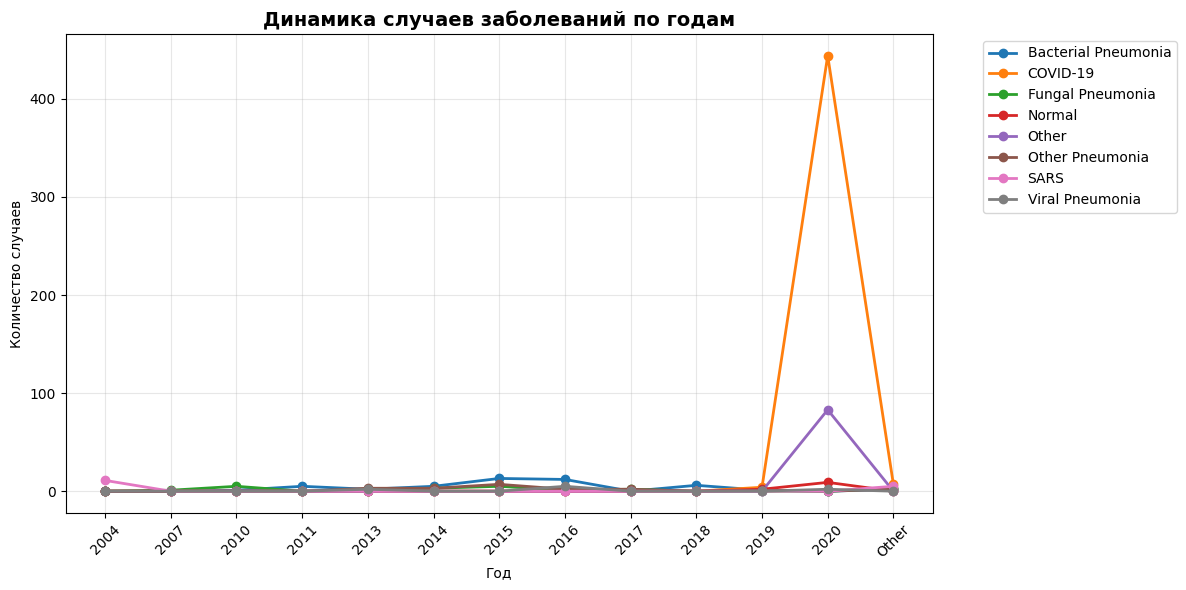


ВАРИАНТ 2: СТЕК AREA CHART (НАКОПЛЕННАЯ ДИНАМИКА)


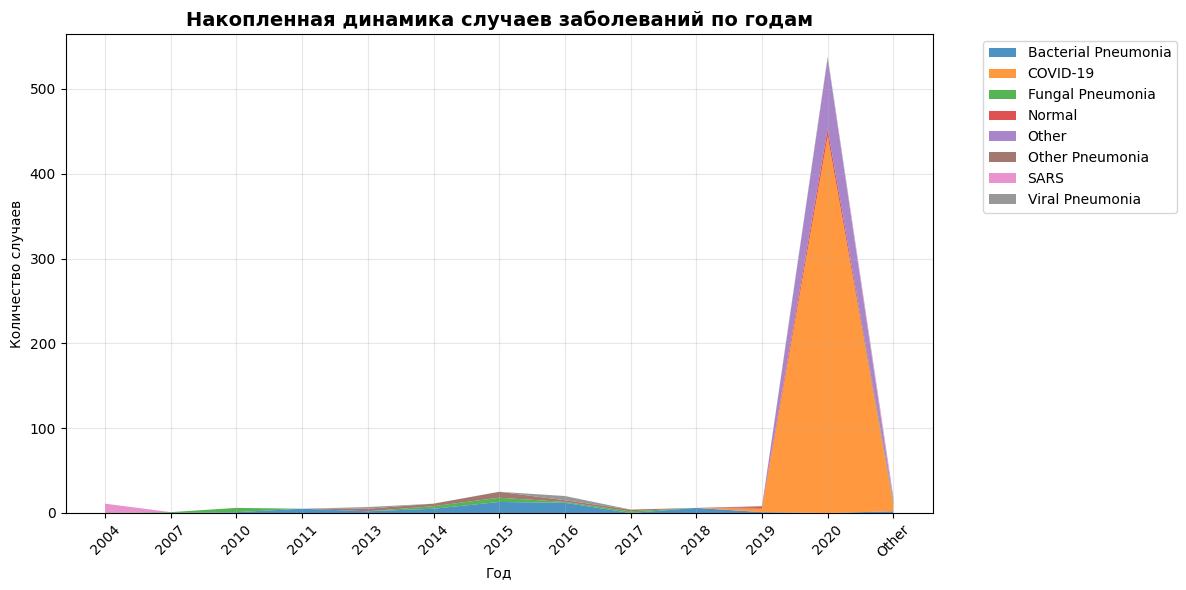


ВАРИАНТ 3: СТОЛБЧАТАЯ ДИАГРАММА (COVID-19 vs ДРУГИЕ)


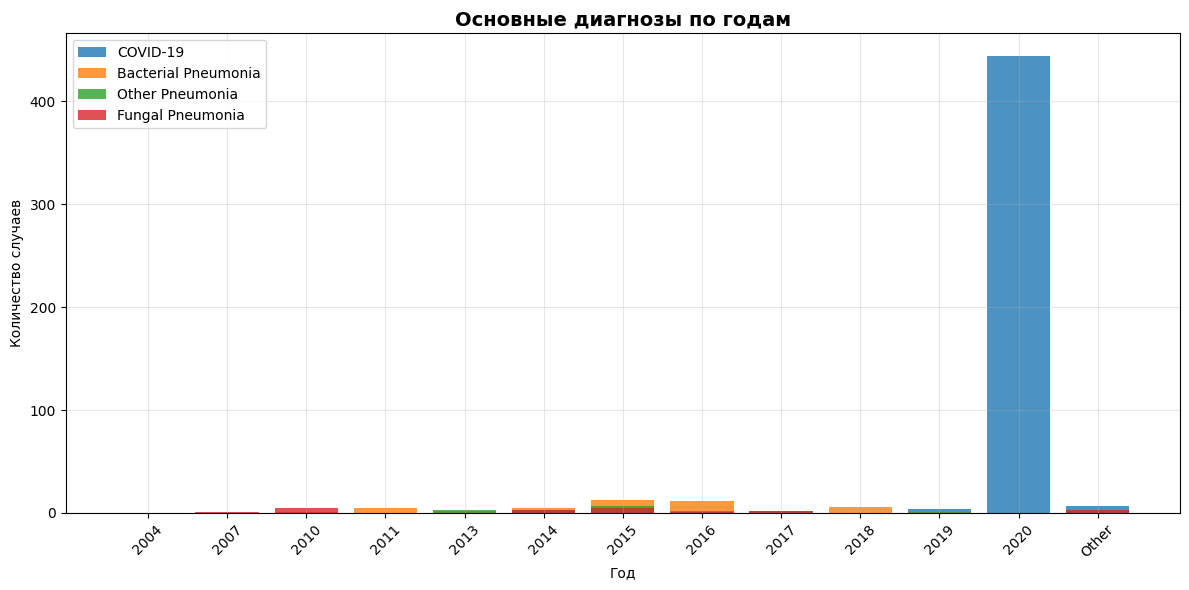

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Преобразуем данные для построения графиков
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ВИЗУАЛИЗАЦИИ ВРЕМЕННЫХ ТРЕНДОВ")
print("=" * 60)

# Получаем данные по годам в формате Pandas DataFrame
yearly_data_pd = spark.sql("""
    WITH YearExtracted AS (
        SELECT
            CASE
                WHEN date LIKE '%2020' THEN '2020'
                WHEN date LIKE '%2019' THEN '2019'
                WHEN date LIKE '%2018' THEN '2018'
                WHEN date LIKE '%2017' THEN '2017'
                WHEN date LIKE '%2016' THEN '2016'
                WHEN date LIKE '%2015' THEN '2015'
                WHEN date LIKE '%2014' THEN '2014'
                WHEN date LIKE '%2013' THEN '2013'
                WHEN date LIKE '%2011' THEN '2011'
                WHEN date LIKE '%2010' THEN '2010'
                WHEN date LIKE '%2007' THEN '2007'
                WHEN date LIKE '%2004' THEN '2004'
                ELSE 'Other'
            END as year,
            finding_category
        FROM df_table
        WHERE date != 'Unknown'
    )
    SELECT
        year,
        finding_category,
        COUNT(*) as cases_count
    FROM YearExtracted
    GROUP BY year, finding_category
    ORDER BY year
""").toPandas()

# Создаем сводную таблицу для построения графиков
pivot_data = yearly_data_pd.pivot_table(
    index='year',
    columns='finding_category',
    values='cases_count',
    fill_value=0
)

# Упорядочиваем годы
year_order = ['2004', '2007', '2010', '2011', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Other']
pivot_data = pivot_data.reindex(year_order)

print("ДАННЫЕ ДЛЯ ПОСТРОЕНИЯ ГРАФИКОВ:")
print(pivot_data)

# Вариант 1: Линейный график динамики заболеваний
print("\nВАРИАНТ 1: ЛИНЕЙНЫЙ ГРАФИК ДИНАМИКИ ЗАБОЛЕВАНИЙ")
plt.figure(figsize=(12, 6))
for column in pivot_data.columns:
    if pivot_data[column].sum() > 0:  # Только категории с данными
        plt.plot(pivot_data.index, pivot_data[column], marker='o', label=column, linewidth=2)

plt.title('Динамика случаев заболеваний по годам', fontsize=14, fontweight='bold')
plt.xlabel('Год')
plt.ylabel('Количество случаев')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Вариант 2: Стек area chart
print("\nВАРИАНТ 2: СТЕК AREA CHART (НАКОПЛЕННАЯ ДИНАМИКА)")
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_data.index, [pivot_data[col] for col in pivot_data.columns],
              labels=pivot_data.columns, alpha=0.8)
plt.title('Накопленная динамика случаев заболеваний по годам', fontsize=14, fontweight='bold')
plt.xlabel('Год')
plt.ylabel('Количество случаев')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Вариант 3: Столбчатая диаграмма по основным диагнозам
print("\nВАРИАНТ 3: СТОЛБЧАТАЯ ДИАГРАММА (COVID-19 vs ДРУГИЕ)")
main_diagnoses = ['COVID-19', 'Bacterial Pneumonia', 'Other Pneumonia', 'Fungal Pneumonia']
plt.figure(figsize=(12, 6))

for diagnosis in main_diagnoses:
    if diagnosis in pivot_data.columns:
        plt.bar(pivot_data.index, pivot_data[diagnosis], label=diagnosis, alpha=0.8)

plt.title('Основные диагнозы по годам', fontsize=14, fontweight='bold')
plt.xlabel('Год')
plt.ylabel('Количество случаев')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ВЫВОДЫ ПО ВРЕМЕННЫМ ТРЕНДАМ:

1. Преобладающая структура возбудителей до COVID-19 (2004-2019 гг):

    Бактериальные пневмонии доминировали в период 2011-2018 годов

    Грибковые пневмонии стабильно присутствовали с 2007 по 2017 год

    Вирусные пневмонии (не COVID-19) регистрировались в 2013 и 2016 годах

    SARS зафиксирован как единичная вспышка в 2004 году

    Структура была разнообразной с чередованием различных патогенов

2. Катастрофический рост случаев пневмонии в 2020 году:

    Общее количество случаев пневмонии увеличилось в 20+ раз по сравнению с предыдущими годами

    COVID-19 составил 82.53% всех случаев в 2020 году (444 из 538 случаев с известной датой)

    Абсолютные цифры: 444 случая COVID-19 против 4-13 случаев других пневмоний в предыдущие годы

    Полное доминирование одного патогена (SARS-CoV-2) вместо разнообразной этиологии предыдущих лет

Эпидемиологическая значимость: Данные наглядно демонстрируют переход от эндемичного уровня респираторных заболеваний к пандемической ситуации с экспоненциальным ростом случаев вирусной пневмонии, вызванной SARS-CoV-2.

In [ ]:
# Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
print("ЗАПРОС 5: СТАТИСТИКА ПО ПРОЕКЦИЯМ СНИМКОВ И СВЯЗИ С ДИАГНОЗАМИ")
print("=" * 70)

query_5 = """
SELECT
    view,
    finding_category,
    COUNT(*) as cases_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view), 2) as percentage_in_view,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY finding_category), 2) as percentage_in_diagnosis
FROM df_table
GROUP BY view, finding_category
ORDER BY view, cases_count DESC
"""

# Выполняем запрос
result_5 = spark.sql(query_5)
print("ПЕРВЫЕ 30 СТРОК РЕЗУЛЬТАТОВ:")
result_5.show(30, truncate=False)

# Дополнительный анализ: общая статистика по проекциям
print("\nОБЩАЯ СТАТИСТИКА ПО ПРОЕКЦИЯМ СНИМКОВ:")
view_summary = spark.sql("""
    SELECT
        view,
        COUNT(*) as total_cases,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM df_table), 2) as percentage_total
    FROM df_table
    GROUP BY view
    ORDER BY total_cases DESC
""")
view_summary.show()

ЗАПРОС 5: СТАТИСТИКА ПО ПРОЕКЦИЯМ СНИМКОВ И СВЯЗИ С ДИАГНОЗАМИ
ПЕРВЫЕ 30 СТРОК РЕЗУЛЬТАТОВ:
+---------+-------------------+-----------+------------------+-----------------------+
|view     |finding_category   |cases_count|percentage_in_view|percentage_in_diagnosis|
+---------+-------------------+-----------+------------------+-----------------------+
|AP       |COVID-19           |146        |71.92             |25.00                  |
|AP       |Other Pneumonia    |17         |8.37              |18.09                  |
|AP       |Bacterial Pneumonia|13         |6.40              |17.81                  |
|AP       |SARS               |8          |3.94              |50.00                  |
|AP       |Viral Pneumonia    |6          |2.96              |37.50                  |
|AP       |Normal             |5          |2.46              |22.73                  |
|AP       |MERS               |4          |1.97              |40.00                  |
|AP       |Tuberculosis       |2      

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("ВИЗУАЛИЗАЦИЯ СТАТИСТИКИ ПО ПРОЕКЦИЯМ СНИМКОВ")
print("=" * 50)

# Получаем данные для визуализации
view_data_pd = spark.sql("""
    SELECT
        view,
        finding_category,
        COUNT(*) as cases_count
    FROM df_table
    GROUP BY view, finding_category
    ORDER BY view, cases_count DESC
""").toPandas()

view_totals_pd = spark.sql("""
    SELECT
        view,
        COUNT(*) as total_cases
    FROM df_table
    GROUP BY view
    ORDER BY total_cases DESC
""").toPandas()

print("ОБЩАЯ СТАТИСТИКА ПО ПРОЕКЦИЯМ:")
print(view_totals_pd)

ВИЗУАЛИЗАЦИЯ СТАТИСТИКИ ПО ПРОЕКЦИЯМ СНИМКОВ
ОБЩАЯ СТАТИСТИКА ПО ПРОЕКЦИЯМ:
        view  total_cases
0         PA          344
1  AP Supine          234
2         AP          203
3          L           84
4      Axial           68
5    Coronal           16
6   AP Erect            1


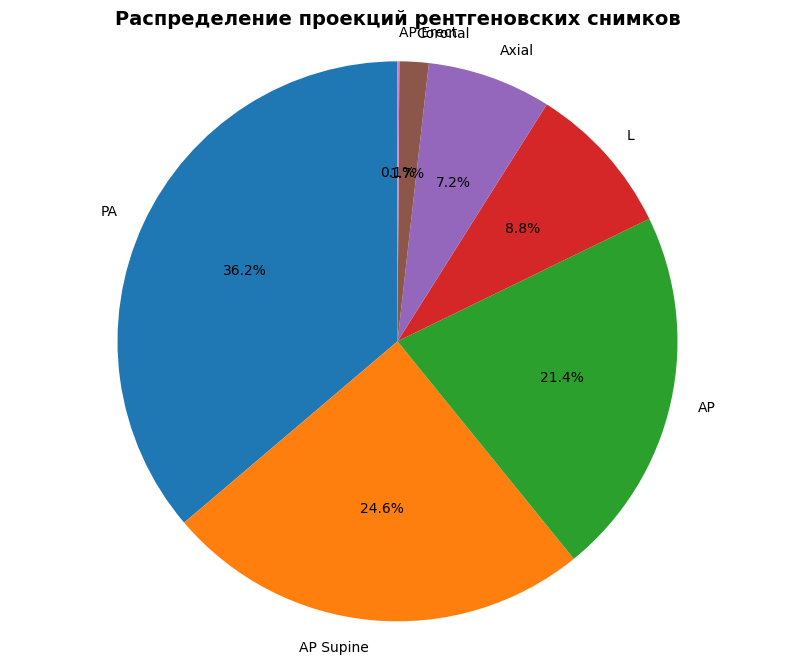

In [ ]:
plt.figure(figsize=(10, 8))
plt.pie(view_totals_pd['total_cases'], labels=view_totals_pd['view'], autopct='%1.1f%%', startangle=90)
plt.title('Распределение проекций рентгеновских снимков', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

<Figure size 1200x800 with 0 Axes>

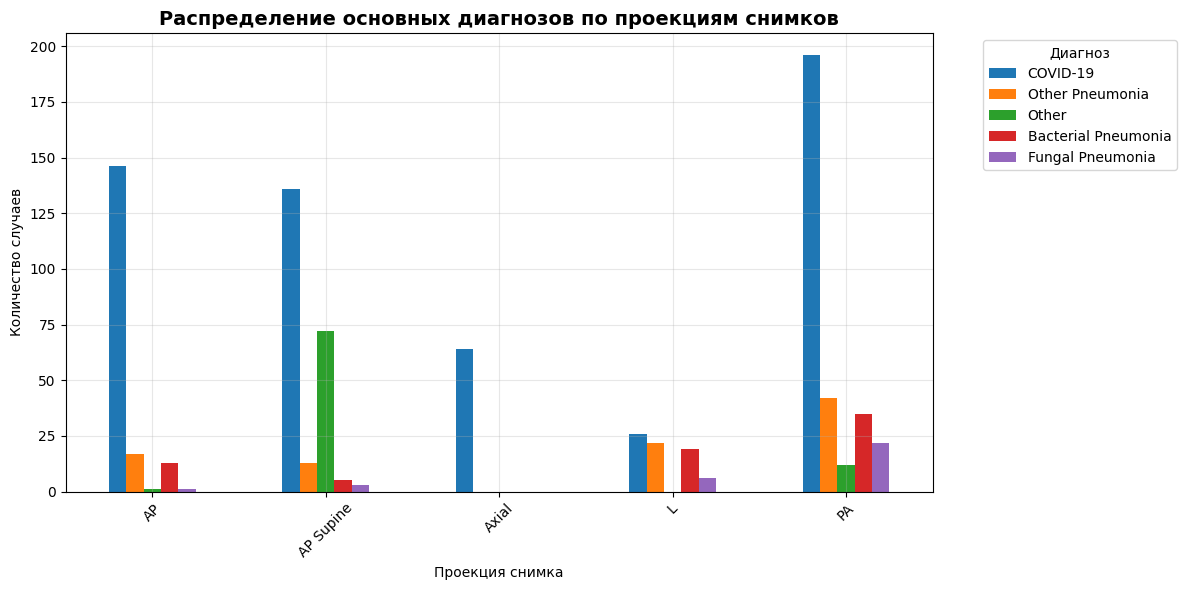

In [ ]:
# Фильтруем топ-5 проекций
top_views = view_totals_pd.head(5)['view'].tolist()
filtered_data = view_data_pd[view_data_pd['view'].isin(top_views)]

plt.figure(figsize=(12, 8))
pivot_data = filtered_data.pivot_table(
    index='view',
    columns='finding_category',
    values='cases_count',
    fill_value=0
)

# Берем топ-5 диагнозов для визуализации
top_diagnoses = pivot_data.sum().nlargest(5).index
pivot_data[top_diagnoses].plot(kind='bar', figsize=(12, 6))
plt.title('Распределение основных диагнозов по проекциям снимков', fontsize=14, fontweight='bold')
plt.xlabel('Проекция снимка')
plt.ylabel('Количество случаев')
plt.legend(title='Диагноз', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ГРАФИК 3: HEATMAP СВЯЗЕЙ ПРОЕКЦИЙ И ДИАГНОЗОВ


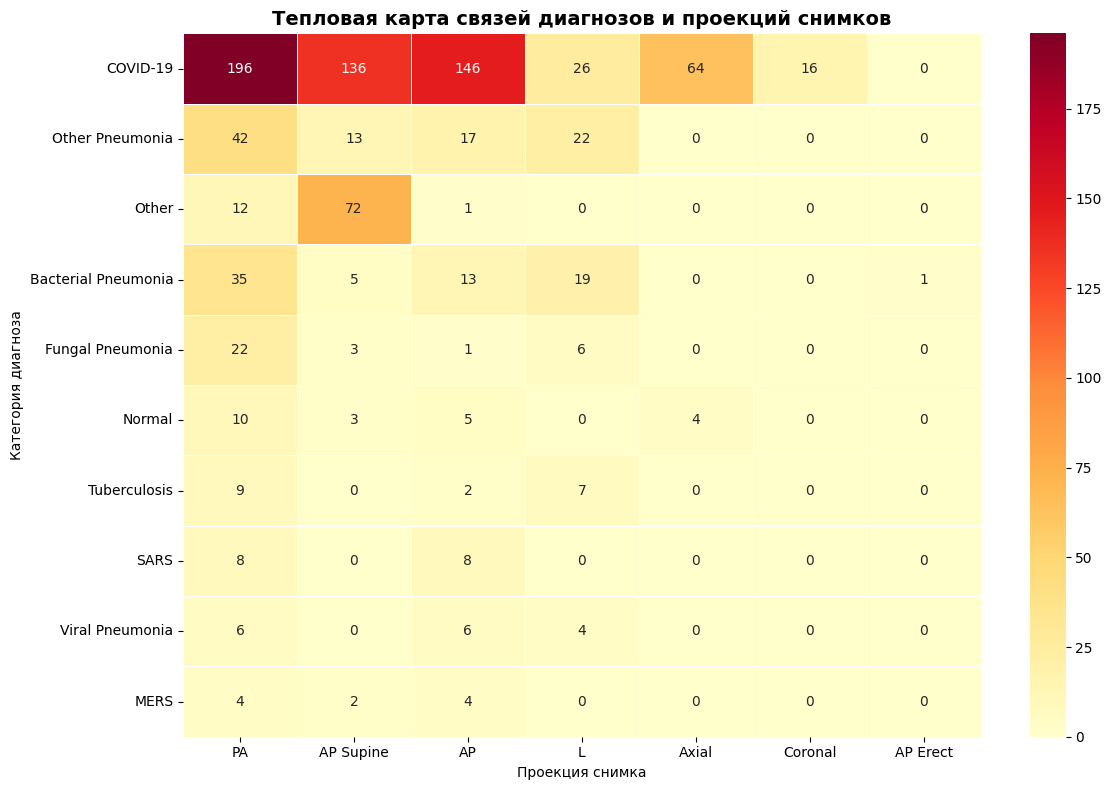


ЧИСЛОВЫЕ ДАННЫЕ ДЛЯ HEATMAP:
view                  PA  AP Supine   AP   L  Axial  Coronal  AP Erect
finding_category                                                      
COVID-19             196        136  146  26     64       16         0
Other Pneumonia       42         13   17  22      0        0         0
Other                 12         72    1   0      0        0         0
Bacterial Pneumonia   35          5   13  19      0        0         1
Fungal Pneumonia      22          3    1   6      0        0         0
Normal                10          3    5   0      4        0         0
Tuberculosis           9          0    2   7      0        0         0
SARS                   8          0    8   0      0        0         0
Viral Pneumonia        6          0    6   4      0        0         0
MERS                   4          2    4   0      0        0         0


In [ ]:
# ГРАФИК 3: Heatmap связей проекций и диагнозов (ИСПРАВЛЕННЫЙ)
print("ГРАФИК 3: HEATMAP СВЯЗЕЙ ПРОЕКЦИЙ И ДИАГНОЗОВ")

plt.figure(figsize=(12, 8))
heatmap_data = view_data_pd.pivot_table(
    index='finding_category',
    columns='view',
    values='cases_count',
    fill_value=0
)

# Фильтруем для лучшей читаемости
top_diag_heat = heatmap_data.sum(axis=1).nlargest(10).index
top_views_heat = heatmap_data.sum(axis=0).nlargest(8).index
filtered_heatmap = heatmap_data.loc[top_diag_heat, top_views_heat]

# Преобразуем в целые числа для исправления ошибки формата
filtered_heatmap_int = filtered_heatmap.astype(int)

sns.heatmap(filtered_heatmap_int, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5)
plt.title('Тепловая карта связей диагнозов и проекций снимков', fontsize=14, fontweight='bold')
plt.xlabel('Проекция снимка')
plt.ylabel('Категория диагноза')
plt.tight_layout()
plt.show()

# Дополнительно: таблица с числовыми значениями для проверки
print("\nЧИСЛОВЫЕ ДАННЫЕ ДЛЯ HEATMAP:")
print(filtered_heatmap_int)

 Статистика по проекциям снимков и их связи с диагнозами

Основные выводы:

    Доминирование стандартных проекций:

        PA (задне-передняя) - наиболее распространенная проекция (196 случаев COVID-19)

        AP (передне-задняя) - вторая по популярности (146 случаев COVID-19)

        Supine (горизонтальная) - 136 случаев COVID-19

    Специфические связи проекций и диагнозов:

        COVID-19: равномерно распределен по всем основным проекциям (PA, AP, Supine)

        Other Pneumonia: преобладание в проекциях PA (42) и AP (17)

        Other: уникальное распределение с концентрацией в проекции Supine (72 случая)

        Bacterial Pneumonia: равномерное распределение между PA (35) и AP (13)

    Клинические предпочтения:

        Для COVID-19 используются все основные проекции без выраженного предпочтения

        Проекция Supine активно применяется для категории "Other" (72 из 85 случаев)

        Редкие проекции (Axial, Coronal) практически не используются для пневмоний

    Диагностическая ценность проекций:

        PA проекция остается золотым стандартом для большинства респираторных заболеваний

        AP проекция широко применяется при COVID-19 и бактериальных пневмониях

        Supine проекция имеет специфическое применение для сложных случаев ("Other")

Вывод: Данные подтверждают клиническую практику использования стандартных проекций (PA, AP) для диагностики респираторных заболеваний, включая COVID-19, с сохранением гибкости в выборе проекции в зависимости от клинической ситуации.

Общий вывод

    Демографические особенности пациентов с COVID-19:
        Среди пациентов с диагнозом COVID-19 преобладают лица старше 50 лет (средний возраст — 56.3 года). Это подтверждает эпидемиологические наблюдения о повышенной уязвимости пожилых людей к коронавирусной инфекции.
        Выявлена значительная доля пропусков в данных о возрасте (25% записей), что ограничивает полный демографический анализ. Для будущих исследований рекомендуется более строгая валидация данных на этапе сбора.
    Гендерный дисбаланс:
        В датасете наблюдается выраженный гендерный дисбаланс: 64% пациентов — мужчины. Особенно это заметно в группах с диагнозами COVID-19, грибковой пневмонией и туберкулезом. Однако в категории SARS наблюдается обратная тенденция (преобладание женщин). Это указывает на необходимость учета гендерных различий при анализе заболеваний.
    Временные тренды:
        Анализ временных трендов показал резкий рост числа исследований в 2020 году, связанный с пандемией COVID-19. Количество случаев пневмонии увеличилось более чем в 20 раз по сравнению с предыдущими годами. В 2020 году COVID-19 составил 82.53% всех зарегистрированных случаев.
        До 2020 года наблюдалось разнообразие этиологии респираторных заболеваний, включая бактериальные, грибковые и вирусные пневмонии. Пандемия привела к доминированию одного патогена (SARS-CoV-2).
    Особенности проекций снимков:
        Наиболее распространенной проекцией снимков является PA (задне-передняя), которая составляет большую часть данных. Различные проекции снимков имеют разное распределение диагнозов, что важно учитывать при разработке моделей машинного обучения.
        Тепловая карта (heatmap) показала сильную связь между проекцией AP Supine и диагнозом COVID-19, что может быть связано с тяжестью состояния пациентов.
    Проблемы качества данных:
        Основные трудности связаны с неполнотой метаданных:
            62% записей имеют неизвестный статус выживаемости (survival).
            38% записей имеют неизвестный или неясный результат ПЦР-теста (RT_PCR_positive).
            Дисбаланс по полу и возрасту ограничивает репрезентативность данных для молодых возрастных групп и женщин.
        Эти ограничения требуют осторожной интерпретации результатов и учета при разработке аналитических моделей.
    Рекомендации по улучшению системы:
        Усилить валидацию данных на этапе сбора, особенно для полей age, sex, survival и RT_PCR_positive.
        Расширить датасет для повышения репрезентативности молодых возрастных групп и женщин.
        Учитывать сезонные колебания при анализе временных трендов.
        Использовать информацию о проекциях снимков для улучшения точности диагностических моделей.